# Machine Learning Model for "House Prices - Advanced Regression Techniques" Competition in Kaggle

Now we will create a machine learning model for the competition
"House Prices - Advanced Regression Techniques" in Kaggle.
The machine learning algorithm that we will use is the
<b>extreme gradient boosting</b> provided by <i>xgboost</i> library.

## Data Setup

In [1]:
# Libraries____________________________________________________________________

# Pandas:
import pandas as pd

# Numpy:
import numpy as np

# Scikit Learn:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# XGBoost:
from xgboost import XGBRegressor

# Matplotlib:
import matplotlib.pyplot as plt
import seaborn as sns

# Pickle:
import pickle

In [2]:
# Dataset location in my local drive:
data_local_dir = "house-prices-advanced-regression-techniques/train.csv"

# Building a dataframe from the dataset:
data = pd.read_csv(data_local_dir, index_col= "Id")
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


## Exploratory Data Analysis

In [3]:
# The columns in the dataframe:
all_columns = list(data.columns)

### Refining The Existing Data Based on the Data Description

In the dataset folder, we are given a text file that provides the information
about the dataset. One insightful information is about several 'null' values
in some categorical columns. It turns out that the 'null' values were
intentional as it reflects somewhat data zero for the columns. Therefore, we
replaced such 'null' values with strings to improve the model.

In [4]:
# Now we refine the data based on the data description:

data_ref = data.copy()

# 1. Alley
# Null values in Alley means "no alley access" based on the description.
# Hence to prevent the computer to identify such values as missing values,
# we impute the missing values with string "NoAcc"
data_ref["Alley"] = data_ref["Alley"].fillna("NoAcc")

# 2. MasVnrType
# In column MasVnrType, the missing values actually refer to inexistence of
# masonry veneer type. Hence to prevent the computer to identify such values
# as missing values, we impute the missing values with string "Nothing".
data_ref["MasVnrType"] = data_ref["MasVnrType"].fillna("Nothing")

# 3. BsmtQual
# In this column, missing values refer to the absence of basements. Hence
# we need to impute the missing values with string "NoBase".
data_ref["BsmtQual"] = data_ref["BsmtQual"].fillna("NoBase")

# 4. BsmtCond
# In this column, missing values refer to the absence of basements.
# Hence we impute the missing values with string "NoBase".
data_ref["BsmtCond"] = data_ref["BsmtCond"].fillna("NoBase")

# 5. BsmtFinType1
# In this column, missing values refer to the absence of basement.
# Hence we impute the missing values with string "NoBase".
data_ref["BsmtFinType1"] = data_ref["BsmtFinType1"].fillna("NoBase")

# 6. BsmtFinType2
# In this column, missing values refer to the absence of basement.
# Hence we impute the missing values with string "NoBase".
data_ref["BsmtFinType2"] = data_ref["BsmtFinType2"].fillna("NoBase")

# 7. FireplaceQu
# In this column, missing values refer to the absence of fire place.
# Hence we impute the missing values with string "NoFirePlace".
data_ref["FireplaceQu"] = data_ref["FireplaceQu"].fillna("NoFirePlace")

# 8. GarageType
# In this column, missing values refer to the absence of garage.
# Hence we impute the missing values with string "NoGarage".
data_ref["GarageType"] = data_ref["GarageType"].fillna("NoGarage")

# 9. GarageFinish
# In this column, missing values refer to the absence of garage.
# Hence we impute the missing values with string "NoGarage".
data_ref["GarageFinish"] = data_ref["GarageFinish"].fillna("NoGarage")

# 10. GarageQual
# In this column, missing values refer to the absence of garage.
# Hence we impute the missing values with string "NoGarage".
data_ref["GarageQual"] = data_ref["GarageQual"].fillna("NoGarage")

# 11. GarageCond
# In this column, missing values refer to the absence of garage.
# Hence we impute the missing values with string "NoGarage".
data_ref["GarageCond"] = data_ref["GarageCond"].fillna("NoGarage")

# 12. PoolQC
# In this column, missing values refer to the absence of pool.
# Hence we impute the missing values with string "NoPool".
data_ref["PoolQC"] = data_ref["PoolQC"].fillna("NoPool")

# 13. Fence
# In this column, missing values refer to the absence of fence.
# Hence we impute the missing values with string "NoFence".
data_ref["Fence"] = data_ref["Fence"].fillna("NoFence")

# 14. MiscFeature
data_ref["MiscFeature"] = data_ref["MiscFeature"].fillna("Nothing")

In [5]:
# Let us check wheter there are missing values in the column "SalePrice":
print("Existence of missing values in column SalePrice:",
      data_ref.isnull().any()["SalePrice"])

Existence of missing values in column SalePrice: False


### General Info

In [6]:
# The info of the data:
nn_count = data_ref.count()
info_dict = {'Columns': data_ref.columns,
             'Non-Null Count': [nn_count[col] for col in data_ref.columns],
             'Data Types': [data_ref[col].dtype for col in data_ref.columns]
            }
info_df = pd.DataFrame(info_dict)
info_df

,Columns,Non-Null Count,Data Types
0,MSSubClass,1460,int64
1,MSZoning,1460,object
2,LotFrontage,1201,float64
3,LotArea,1460,int64
4,Street,1460,object
...,...,...,...
75,MoSold,1460,int64
76,YrSold,1460,int64
77,SaleType,1460,object
78,SaleCondition,1460,object


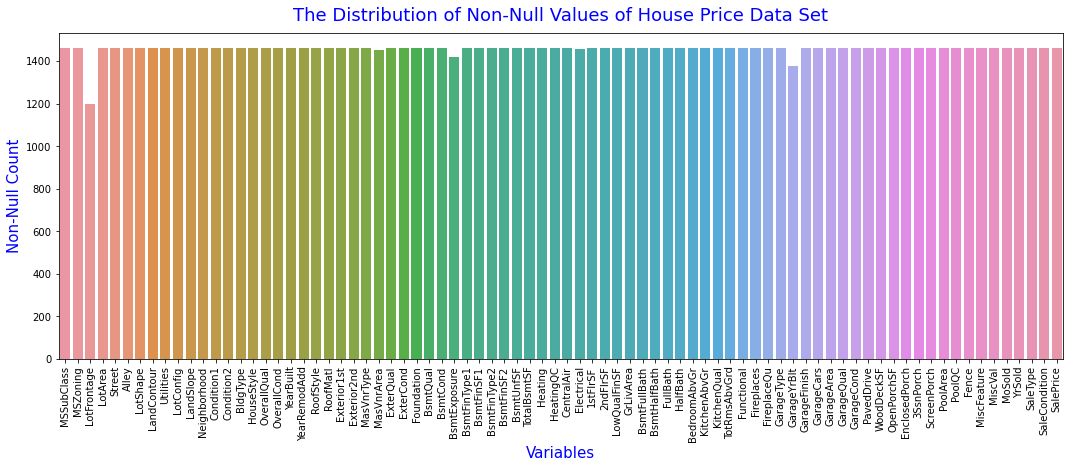

In [7]:
# Let us visualialise the data count of non-null values:

# Barchart
plt.figure(figsize= (18, 6))
sns.barplot(x= info_df['Columns'], y= info_df['Non-Null Count'])
plt.title("The Distribution of Non-Null Values of House Price Data Set",
          pad= 12, fontsize= 18, color= 'blue')
plt.xlabel("Variables", fontsize= 15, color= 'blue')
plt.ylabel("Non-Null Count", fontsize= 15, color= 'blue')
plt.xticks(rotation= 'vertical')
plt.show()

### Data Stat

In [8]:
# The stat of the data is given by
data_stat = data_ref.describe().T
data_stat

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


### Correlation Between Features

In [9]:
# The features in the data set are all the columns except 'SalePrice'.
# Now we will check the correlation betweeen these features.
data_all_ft = data_ref.drop(['SalePrice'], axis= 1)
corr_ft = data_all_ft.corr()
corr_ft

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
LotFrontage,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,...,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450
LotArea,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
OverallQual,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
OverallCond,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
YearBuilt,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
YearRemodAdd,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
MasVnrArea,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201
BsmtFinSF1,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,...,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359
BsmtFinSF2,-0.065649,0.049900,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072319,-0.050117,1.000000,...,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706


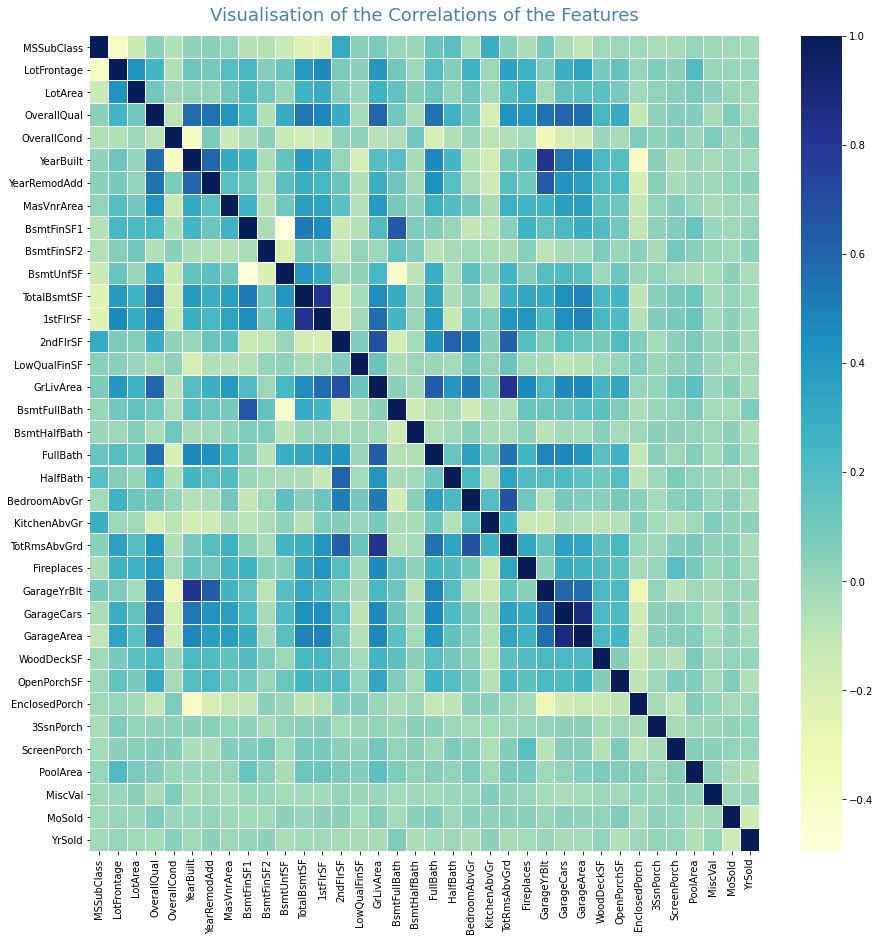

In [10]:
# To easily identify the correlations, we will visualise the correlations into a heatmap:
plt.figure(figsize= (15, 15))
sns.heatmap(corr_ft, cmap= "YlGnBu", linewidths= 0.1)
plt.title("Visualisation of the Correlations of the Features",
          fontsize= 18, pad= 15, color= 'steelblue')
plt.show()

## Building Model

### Setting the Feature and Target

In [11]:
# The feature and the target for the machine learning model
# are given as follows:
X, y = data_ref.drop(["SalePrice"], axis= 1), data_ref.SalePrice

### Model Guideline

For all the model, we will use XGBRegressor algorithm with cross validation score.
We will seek the best number of estimator for the ML model. We determine the range
of the numbers as follows:

In [12]:
# The range of n_estimators for XGBRegressor:
range_n_est = list(range(100, 500, 10))

### General Model Score Function

In [13]:
# Now we build a function to measure the performance of some different
# variations of the model:

def model_score(ft, targ, n_est, prep, n_cv= 5):
    """
        This function measures the performance of our xgboost model.
    We set several variables, namely 'ft' as the features, 'targ' as
    the target, 'n_est' as the selected number of estimators for the
    XGBRegressor, 'prep' as a preprocessing protocol (may be in the form
    of pipelines), and 'n_cv' as the number of 'cv' parameter in
    'cross_val_score'.
    """
    model = XGBRegressor(n_estimators= n_est, learning_rate= 0.05, n_jobs= 6)
    model_pipeline = Pipeline(steps= [('preprocessor', prep),
                                  ('model', model)])
    score = -1 * cross_val_score(model_pipeline,
                                 ft,
                                 targ,
                                 cv= n_cv,
                                 scoring= "neg_mean_absolute_error")
    return score.mean()

In [14]:
print(model_score.__doc__)


        This function measures the performance of our xgboost model.
    We set several variables, namely 'ft' as the features, 'targ' as
    the target, 'n_est' as the selected number of estimators for the
    XGBRegressor, 'prep' as a preprocessing protocol (may be in the form
    of pipelines), and 'n_cv' as the number of 'cv' parameter in
    'cross_val_score'.
    


### Method 1: Dropping All Missing Values & Object Data

In [15]:
# In order to work well with pipline, we create a class for dropping columns
# in our dataframe:
class ColumnsDropper:
    def __init__(self, cols):
        self.cols = cols
        
    def transform(self, ft, targ= None):
        return ft.drop(self.cols, axis= 1)
    
    def fit(self, ft, targ= None):
        return self

In [16]:
# For the first method, we drop all the columns with missing values
# and the categorical columns:
cols_drop_m1 = [col for col in data_ref.columns
                if (data_ref.isnull().any()[col]
                or data_ref[col].dtype == 'object')
               ]

# Preprocessor for method 1:
prep_m1 = Pipeline(steps= [('col_drop', ColumnsDropper(cols_drop_m1))])

### Method 2: Dropping All Missing Values

In [17]:
# Columns with missing values:
cols_nan_m2 = [col for col in data_ref.columns
               if data_ref.isnull().any()[col]]

# Categorical columns:
cat_cols_m2 = [col for col in data_ref.columns
               if data_ref[col].dtype == 'object'
               and not (col in cols_nan_m2)]

# Pipelines:
cat_pipe_m2 = Pipeline(
    steps= [('oh_encoder',
             OneHotEncoder(handle_unknown= 'ignore'))
           ]
)
cat_trans_m2 = ColumnTransformer(
    transformers= [('oh_encoding', cat_pipe_m2, cat_cols_m2)
                  ]
)

# Preprocesseor for method 2:
prep_m2 = Pipeline(steps= [('drop', ColumnsDropper(cols_nan_m2)),
                           ('cat_trans', cat_trans_m2)]
                  )

### Method 3: Imputing Missing Values, One Hot Encoding & Normalisation

In [18]:
# Numeric Columns:
num_cols_m3 = [col for col in X.columns
               if data_ref[col].dtype in ['int64', 'float64']]

# Categorical Columns:
cat_cols_m3 = [col for col in X.columns
               if data_ref[col].dtype == 'object']

# Pipelines:
num_pipe_m3 = Pipeline(
    steps= [('imputing', SimpleImputer(strategy= 'mean'))]
)
cat_pipe_m3 = Pipeline(
    steps= [('imputing', SimpleImputer(strategy= 'most_frequent')),
            ('oh_encoding', OneHotEncoder(handle_unknown= 'ignore'))
           ]
)

# Column transformation/Preprocessing for method 3:
prep_m3 = ColumnTransformer(
    transformers= [('num_trans', num_pipe_m3, num_cols_m3),
                   ('cat_trans', cat_pipe_m3, cat_cols_m3),
                   ('normalisation', StandardScaler(), num_cols_m3)
                  ]
)

### Scoring of Each Method

#### Setting Up a Dictionary for the Score

In [19]:
# Now we create a dictionary whose keys are the possible numbers of estimators
# for XGBRegressor, and whose values are the model scores given by
# 'model_score' function that we created earlier:
dict_score_model = {
    'Model_1': [model_score(X, y, n, prep_m1) for n in range_n_est],
    'Model_2': [model_score(X, y, n, prep_m2) for n in range_n_est],
    'Model_3': [model_score(X, y, n, prep_m3) for n in range_n_est]
}

#### Setting Up a Data Frame for the Score

In [20]:
# Now we create a dataframe from the dictionary above:
df_score_models = pd.DataFrame(dict_score_model)

# Setting 'range_n_est' as the index for the data frame:
df_score_models.index = range_n_est

#### Making a Visualisastion for the Score

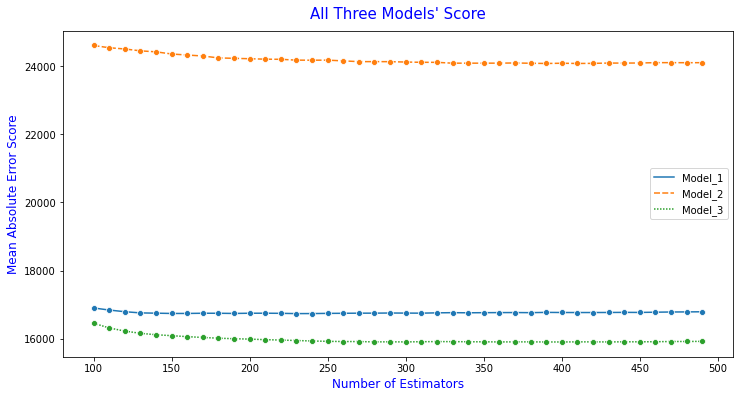

In [55]:
# Now let us visualise the score for the models:
plt.figure(figsize= (12, 6))
sns.lineplot(data= df_score_models, marker= 'o')
plt.title("All Three Models' Score", pad= 12, fontsize= 15, color= 'blue')
plt.xlabel("Number of Estimators", fontsize= 12, color= 'blue')
plt.ylabel("Mean Absolute Error Score", fontsize= 12, color= 'blue')

plt.show()

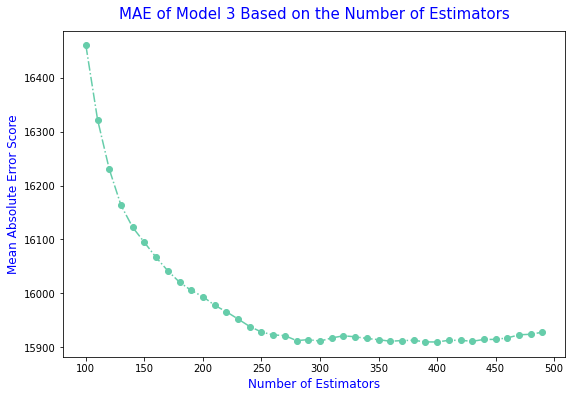

In [69]:
# From the graph above, we can clearly see that 'Model_3' is the best model,
# since it produces the least the mean absolute error scores.
# Hence, let us visualise 'Model_3' into a plotline to observe the best n_estimators
# visually:
plt.figure(figsize= (9, 6))
plt.plot(df_score_models.index, df_score_models['Model_3'],
         marker= 'o', linestyle= '-.', color= 'mediumaquamarine')
plt.title("MAE of Model 3 Based on the Number of Estimators",
          pad= 12, fontsize= 15, color= 'blue')
plt.xlabel("Number of Estimators", fontsize= 12, color= 'blue')
plt.ylabel("Mean Absolute Error Score", fontsize= 12, color= 'blue')
plt.show()

#### Deciding the Best Model

In [70]:
# The best model:
best_model = [
    col for col in df_score_models.columns
    if df_score_models[col].min() == df_score_models.min().min()
][0]
print(f"The best model is {best_model}.")

# The best number of estimators:
best_n_est = [
    n for n, s in zip(range_n_est, df_score_models[best_model])
    if df_score_models[best_model][n] == df_score_models[best_model].min()
][0]
print(f"The best number of estimators = {best_n_est}")
print(f"The best (least) score = {df_score_models.min().min()}")

The best model is Model_3.
The best number of estimators = 400
The best (least) score = 15909.832526220034


### The Chosen Model

Based on the result above, now we desgin the machine learning model that we
will use to predict the house price.

In [71]:
# The model that we will use:
model_in_charge = XGBRegressor(n_estimators= best_n_est,
                               learning_rate= 0.05, n_jobs= 6
                              )
# Preprocessing in use:
final_preprocessor = Pipeline(
    steps=[('prep_m3', prep_m3), ('model', model_in_charge)]
)

# Fitting the model:
final_preprocessor.fit(X, y)

Pipeline(steps=[('prep_m3',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imputing',
                                                                   SimpleImputer())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                              

## Answering the Big Question: Prediction

### Data for Prediction (Features)

In [74]:
# The features used for the prediction is given as follows:
fin_features_source = "house-prices-advanced-regression-techniques/test.csv"
fin_features_df = pd.read_csv(fin_features_source, index_col= 'Id')
fin_features_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


### Predicting the Data

In [75]:
fin_pred = final_preprocessor.predict(fin_features_df)

In [76]:
pred_dict = {'Id': fin_features_df.index, 'SalePrice': fin_pred}
pred_df = pd.DataFrame(pred_dict)

In [80]:
# Exporting the result to csv:
# pred_df.to_csv("submission.csv", index= False)

In [82]:
# Checking:
submission_df = pd.read_csv("submission.csv", index_col= 'Id')
submission_df

,SalePrice
Id,
1461,125323.734
1462,155693.520
1463,183131.050
1464,186653.940
1465,186656.050
...,...
2915,81377.080
2916,78497.984
2917,151725.080
